In [19]:
# IMPORT NECESSARY LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# preprocessing functions
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# unsupervised machine learning models
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
# evaluation metrics
from sklearn.metrics import accuracy_score, silhouette_score

In [20]:
# pandas settings
#To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 
# To set the min number of rows displayed
pd.set_option('display.max_rows',5000)

In [21]:
# import data
arrest = pd.read_csv('UsArrests.csv')
state = arrest['City']
arrest = arrest.drop('City', axis = 1)
arrest.index = state
arrest

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.20,236,58,21.20
Alaska,10.00,263,48,44.50
Arizona,8.10,294,80,31.00
Arkansas,8.80,190,50,19.50
California,9.00,276,91,40.60
Colorado,7.90,204,78,38.70
Connecticut,3.30,110,77,11.10
Delaware,5.90,238,72,15.80
Florida,15.40,335,80,31.90


Now we perform some exploratory data analysis to better understand the data and assess its quality

In [22]:
def summary_report(df):
    summary = df.describe()
    # add kurtosis, skewness, minimum, num of blanks 
    extra = pd.DataFrame({i:[arrest[i].skew(),arrest[i].kurtosis(),arrest[i].min(),arrest[i].isnull().sum()] for i in arrest.columns},index = ['kurtosis', 'skewness', 'minimum', 'num of blanks'])
    summary = arrest.describe()
    summary.loc['coefficient of variation'] = summary.loc['std']/summary.loc['mean']
    report = pd.concat([summary,extra],axis = 0)
    return report

In [23]:
summary = summary_report(arrest)
summary

,Murder,Assault,UrbanPop,Rape
count,50.00,50.00,50.00,50.00
mean,7.79,170.76,65.54,21.23
std,4.36,83.34,14.47,9.37
min,0.80,45.00,32.00,7.30
25%,4.08,109.00,54.50,15.07
50%,7.25,159.00,66.00,20.10
75%,11.25,249.00,77.75,26.18
max,17.40,337.00,91.00,46.00
coefficient of variation,0.56,0.49,0.22,0.44
kurtosis,0.39,0.23,-0.23,0.80


From the summary statistics report, we can observe that the median values for murder, rape and assault are less than the mean indicating a positive skew however the skewness statistics indicate otherwise. There does not seem to be large volatility in either of these 4 features as the coefficient of variation is less than or roughly equal to 0.5.

There do not seem to be any completeness data quality issues.

In [24]:
arrest.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


The data types are all float or int64 which are acceptable for machine learning models

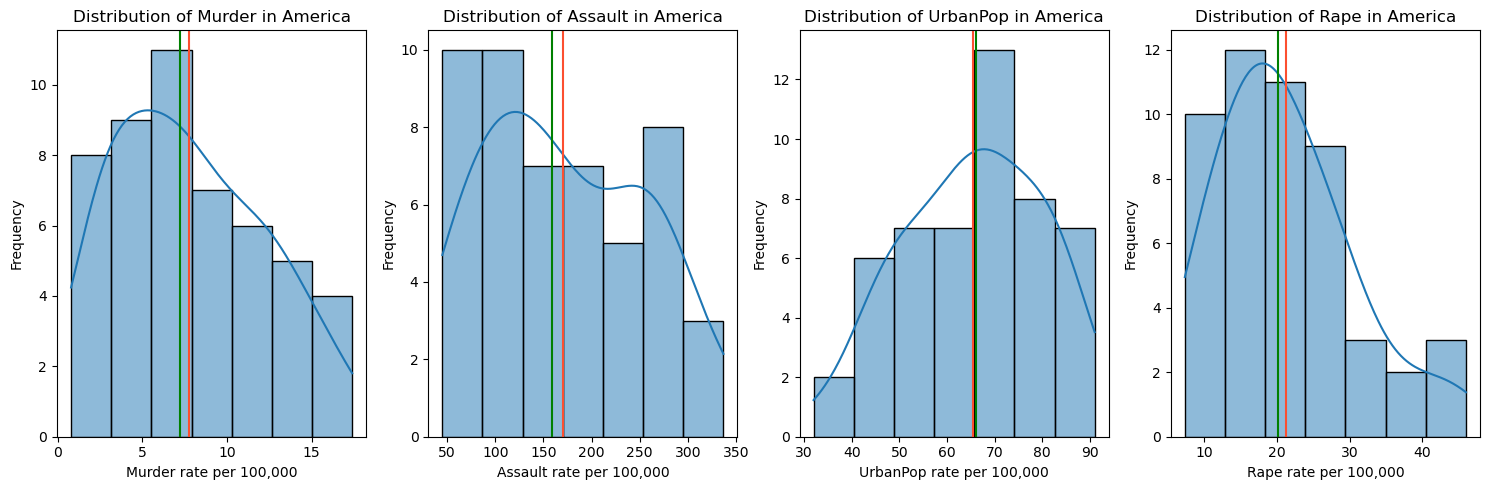

In [25]:
# Plot the distributions of the fields in the dataset
fig,axes = plt.subplots(1,4,figsize=(15, 5))
for index,column in enumerate(arrest.columns):
    sns.histplot(data = arrest[column],kde = 'True',ax = axes[index])
    axes[index].axvline(arrest[column].mean(), color = '#fc4f30')
    axes[index].axvline(arrest[column].median(), color = 'g')
    axes[index].set_xlabel(f'{column} rate per 100,000')
    axes[index].set_ylabel('Frequency')
    axes[index].set_title(f'Distribution of {column} in America')
plt.tight_layout()
plt.show() # must be outside of loop otherwise it will exit the loop.

The distributions of each crime and urbanpop rate do not seem normally distributed due to their skewness and bimodal behaviour. The median and mean values however are very close. Notice that the assault rate values are significantly bigger than the murder, rape or urbanpop rate. This could potentially affect the outputs of our unsupervised learning models therefore we should apply Standard scaling or minmax scaling. Since these distributions are not normal, minmaxscaler seems more appropriate. However, to conduct principal component analysis we are required to centre the points by subtracting mean and then acquiring the eigenvectors with largest eigenvalues through single value decomposition. In such a case, it is better to use standard scaler to get each feature.

#### Correlation Analysis - understand the relationships between variables

In [26]:
# To make correlation analysis more interesting we will reuse the state variable to create a region variable
arrest['State'] = arrest.index
south = [ 'Alabama', 'Arkansas', 'Delaware', 'Florida', 'Georgia', 'Kentucky', 'Louisiana', 'Maryland', 'Mississippi','North Carolina', 'Oklahoma', 'South Carolina', 'Tennessee', 'Texas', 'Virginia', 'West Virginia']
west = ['Montana', 'Wyoming', 'Colorado', 'New Mexico', 'Idaho', 'Utah', 'Arizona','Nevada','Washington', 'Oregon', 'California', 'Alaska', 'Hawaii']
northeast = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'New Jersey', 'New York', 'Pennsylvania', 'Rhode Island','Vermont']
midwest = ['Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin']

def region(x):
    if x in south:
        return 'south'
    elif x in west:
        return 'west'
    elif x in northeast:
        return 'northeast'
    else:
        return 'midwest'    
arrest['Region'] = arrest['State'].apply(region)
arrest.drop(['State'],axis = 1, inplace = True)

<Figure size 1000x1000 with 0 Axes>

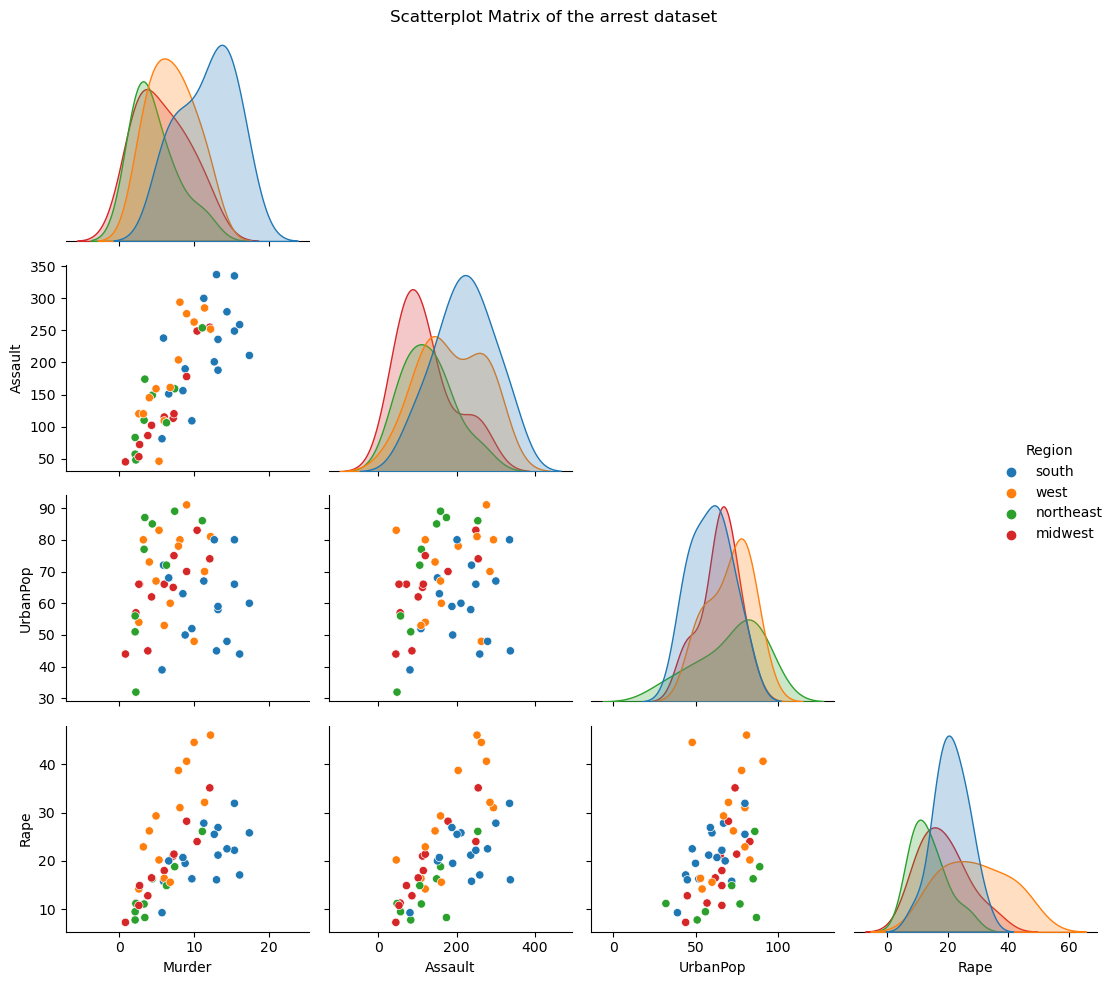

In [27]:
plt.figure(figsize = (10,10))
s = sns.pairplot(arrest,corner = True, hue = 'Region')
s.fig.suptitle('Scatterplot Matrix of the arrest dataset')
plt.tight_layout()
plt.show()

We can see from the scatterplots above the relationships between the features. Moreover notice that we are grouping datapoints by which region of the united states, the states belong. This can help us understand which regions/states are more vulnerable to crimes and which regions/states are more densely populated.

Murder has a strong positive correlation with assault and rape. Western and southern states tend to be on the higher end of the spectrum.

Assault and rape have a strong positive correlation with, western states again being the ones at the higher end of the spectrum for both.

North eastern states are much more densely populated as indicated by their negative skew whilst southern are least densely populated as indicated by their normal bell curve distribution compared to the rest of the distributions.

For individual distributions of crimes, western and southern states are the most negatively skewed indicating higher mean and median cases per 100,000 so generally less safe to live.

<AxesSubplot:>

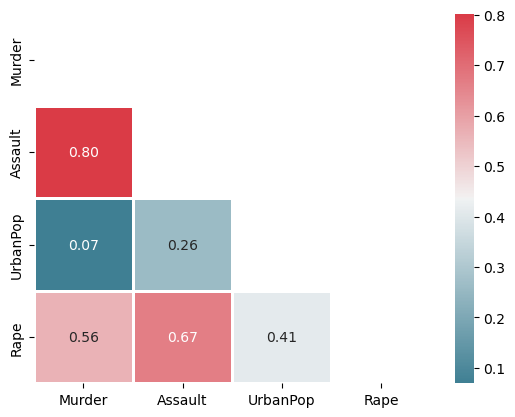

In [28]:
#Heatmap
colormap = sns.diverging_palette(220, 10, as_cmap=True)
corr_df = arrest.drop(['Region'],axis = 1).corr()
dropSelf = np.zeros_like(corr_df)
dropSelf[np.triu_indices_from(dropSelf)] = True
sns.heatmap(corr_df, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=2)


Murder and Assault have the strongest positive correlation. This is mostly because violent cities are likely to have both as one cannot exist without the other. The same crimes can have two outcomes, where a victim survives or dies. If they survive they may be bucketed into assault whereas if they die, it becomes murder. Rape still has a strong correlation with both murder and assault but significantly less strong the other two's relationship.

Urbanpopulation has the strongest positive correlation with rape. This may be due to higher attacks occuring in cities where population densities are quite high and it would be easier in smaller towns to identify rapists, however this may not necessarily be the case towns in Alaska which have low population densities tend to have high rape rates. 

Preprocessing

In [29]:
# we will normalise all of our variables. This is because assault rate will 
# dominate the principal components in our analysis simply due to the magnitude of the values
# To keep it consistent, we will normalise all of our variables
arrest_df = arrest.drop('Region',axis = 1)
X = StandardScaler().fit_transform(arrest_df.values.reshape(-1,4))

### PRINCIPAL COMPONENT ANALYSIS

We will perform principal component analysis to reduce the dimensionality of our dataset. Principal components are vectors that extract information from the different features in the dataset. The magnitude of the loading values of each principal component tell us how important that variable is in composing that principal component. It allows us to summarize large number of variables into a smaller number of variables. Principal components are also eigenvectors with the largest eigenvalues that we can acquire by maximising the variance between the datapoints. By maximimising the variance using lagrange multiplier method, we maintain the structure of the dataset i.e. points close together remain close in our new mapping line and points far away in the original are still far in the mapping line. This mapping line is essentially a vector that does not change as you multiply the covariance matrix to it and can be found by linear algebra (calculating the determinant of Cov matrix - lambda times identity matrix.)

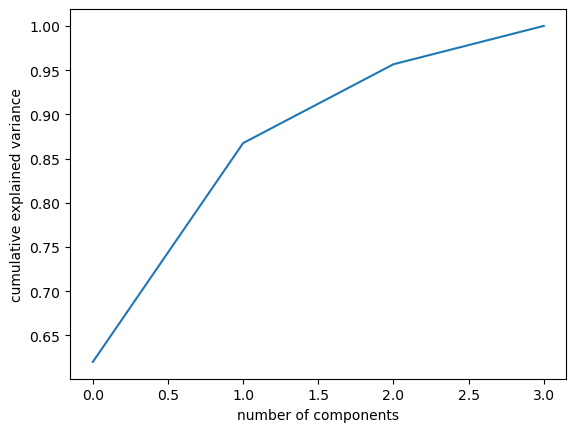

In [30]:
pca_test = PCA().fit(X)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

The chart indicates that the number of components with a cumulative explanation of the variance in the data of 1 are 3 principal components. Therefore we will run our unsupervised model with a parameter of capturing 3 principal components with the greatest eigenvalues.

In [31]:
# Applying PCA

# first we choose number of components to be generated after dimensionality reduction
nr_comps = 3 #e have 4 fields, lets condense the information to 3 as murder and assault are highly correlated 
pca = PCA(n_components=nr_comps)

# obtain components
principal_components = pca.fit_transform(X)

# tranforming numpy array into pandas dataframe
pca_df = pd.DataFrame(data = principal_components,columns = ['PC1','PC2','PC3'])

In [32]:
# the below is the result of the dot product between the eigenvector and the arrest data matrix
pca_df

,PC1,PC2,PC3
0,0.99,1.13,-0.44
1,1.95,1.07,2.04
2,1.76,-0.75,0.05
3,-0.14,1.12,0.11
4,2.52,-1.54,0.60
5,1.51,-0.99,1.10
6,-1.36,-1.09,-0.64
7,0.05,-0.33,-0.72
8,3.01,0.04,-0.58
9,1.64,1.28,-0.34


In [33]:
pca_df.describe()

,PC1,PC2,PC3
count,50.00,50.00,50.00
mean,-0.00,0.00,-0.00
std,1.59,1.00,0.60
min,-2.99,-1.57,-1.37
25%,-1.12,-0.73,-0.43
50%,-0.18,-0.15,0.03
75%,1.37,0.77,0.26
max,3.01,2.39,2.04


In [34]:
# eigenvector equations
pca.components_

array([[ 0.53589947,  0.58318363,  0.27819087,  0.54343209],
       [ 0.41818087,  0.1879856 , -0.87280619, -0.16731864],
       [-0.34123273, -0.26814843, -0.37801579,  0.81777791]])

The below equations represent our 3 principal components which extract information from our dataset and reduce dimensionality. The equations show us how much each variable plays a role in deriving the principal component. The larger the absolute value of the coefficient, the more important the corresponding variable is in calculating the component.

In general the first principal component tells us the general levels of crime, as these coefficients/eigenvectors have large positive values, in a state whilst the second principal component tells us how about the density of the population in the state as urbanpop has a large negative value.

In [35]:
list_pca = pca.components_.tolist()
dict_pca = {f'Principal Component {index+1}':value for index,value in enumerate(list_pca)}
dict_pca
for key,value in dict_pca.items():
        print(f'{key} = {round(value[0],2)}*Murder + {round(value[1],2)}*Assault + {round(value[2],2)}*UrbanPop + {round(value[3],2)}*Rape')

Principal Component 1 = 0.54*Murder + 0.58*Assault + 0.28*UrbanPop + 0.54*Rape
Principal Component 2 = 0.42*Murder + 0.19*Assault + -0.87*UrbanPop + -0.17*Rape
Principal Component 3 = -0.34*Murder + -0.27*Assault + -0.38*UrbanPop + 0.82*Rape


In [36]:
pca_var = pca.explained_variance_ratio_.tolist()
dict_pca_var = {f'Proportion of Variance Explained by PC{index+1}':value for index,value in enumerate(pca_var)}
dict_pca_var

{'Proportion of Variance Explained by PC1': 0.6200603947873736,
 'Proportion of Variance Explained by PC2': 0.2474412881349602,
 'Proportion of Variance Explained by PC3': 0.08914079514520745}

These are also the largest eigenvalues of the eigenvectors array by pca.components_. We see that PC1 explains the greatest amount of variance followed by PC2. We can see that PC3 barely explains any variation in the dataset, so we should not focus further on this in our analysis.

Visualising the principal components: biplot

In [37]:
arrest_region = arrest['Region'].reset_index(drop = True)
arrest_region
pca_df1 = pd.concat([pca_df,arrest_region],axis = 1)
pca_df1

,PC1,PC2,PC3,Region
0,0.99,1.13,-0.44,south
1,1.95,1.07,2.04,west
2,1.76,-0.75,0.05,west
3,-0.14,1.12,0.11,south
4,2.52,-1.54,0.60,west
5,1.51,-0.99,1.10,west
6,-1.36,-1.09,-0.64,northeast
7,0.05,-0.33,-0.72,south
8,3.01,0.04,-0.58,south
9,1.64,1.28,-0.34,south


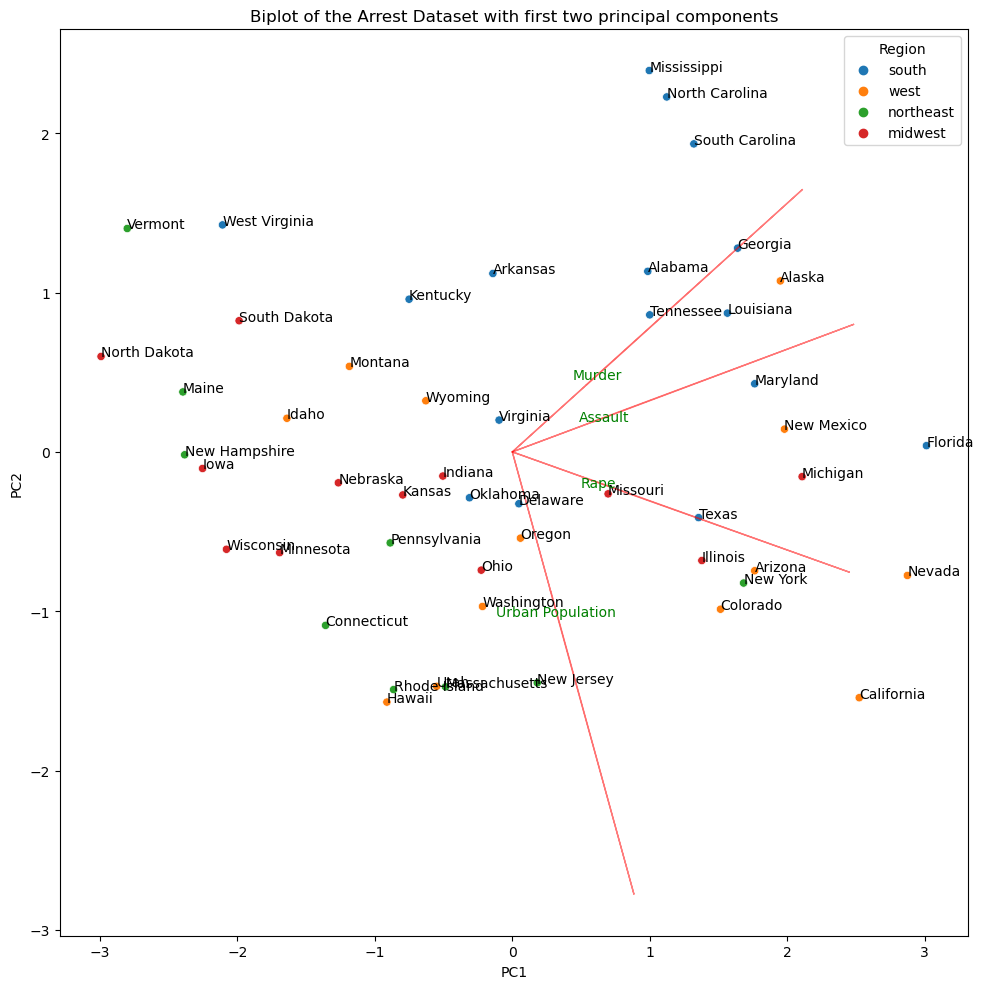

In [40]:
# biplot
state = arrest.index
coefficients = np.transpose(pca.components_[0:2, :])
columns = ['Murder','Assault', 'Urban Population', 'Rape']
def biplot(pca_data,eigen_vectors,states,columns):
    plt.figure(figsize = (10,10))
    pca_data1 = pca_data.iloc[:,0]
    pca_data2 = pca_data.iloc[:,1]
    sns.scatterplot(data = pca_data, x =pca_data1,y = pca_data2, hue = 'Region')
    
    # annotate the points on the pca data scatter plot with the state they belong to
    for index,value in enumerate(states):
        plt.annotate(value,(pca_data1[index],pca_data2[index]))
    
    # add the loading plot and its labels
    # loop through the rows of the matrix so we can get plot all the principal component eigenvectors on a chart with values of pc1 and pc2. This shows us the directions in which each original column influences the principal components
    n = coefficients.shape[0]
    for i in range(n):
        plt.arrow(0,0,eigen_vectors[i,0], eigen_vectors[i,1],color = 'r',alpha = 0.5, head_length = 2)
        plt.text(eigen_vectors[i,0]* 1.15, eigen_vectors[i,1] * 1.15, columns[i], color = 'g', ha = 'center', va = 'center')
    
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title('Biplot of the Arrest Dataset with first two principal components')
    plt.tight_layout()
    
biplot(pca_df1,coefficients,state,columns)

The loading plot visually shows the results for the first two components. Rape, Murder and Assault have large positive loadings on component 1, so this component measure crime rates. Urban Population has large negative loadings on component 2, so this component primarily measures a state's population density.

Southern and Western states are more along principal component 1's positive side indicating these states suffer higher crime rates whilst northeastern states and midwestern are more closer to the negative vector of urbanpop which has large negative loadings on component 2 indicating they have higher population densities.



In [41]:
# feature importance
pd.DataFrame({'Features': ['Murder','Assault', 'Urban Population', 'Rape'],
            'PC1_Importance': abs(pca.components_[0]),
             'PC2_Importance': abs(pca.components_[1])})

,Features,PC1_Importance,PC2_Importance
0,Murder,0.54,0.42
1,Assault,0.58,0.19
2,Urban Population,0.28,0.87
3,Rape,0.54,0.17


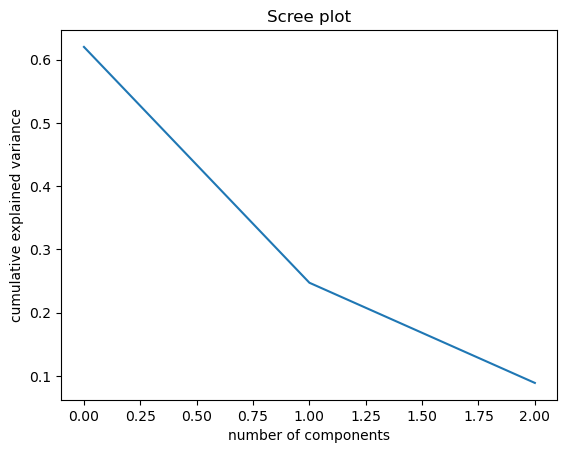

In [42]:
# scree plot - we already looked at cumulative sum of explained variance so we will look at scree plot only
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

In this result, the first 2 principal components explain at least 70% of the variation in the data. The scree plot shows that the cumulative explained variance start to form a straight line at an angle after the 1st principal component. If 70% is an adequate amount of variation explained in the data, then you should use the 2 principal components.

### k means clustering & Aglomerative clustering

Now we will discover how many clusters exist within our dataset

#### K-means clustering

In [43]:
X_clustering = pca_df.iloc[:,0:2].values.reshape(-1,2)

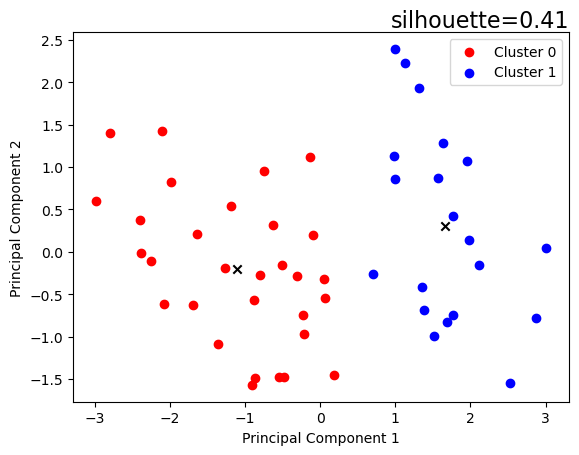

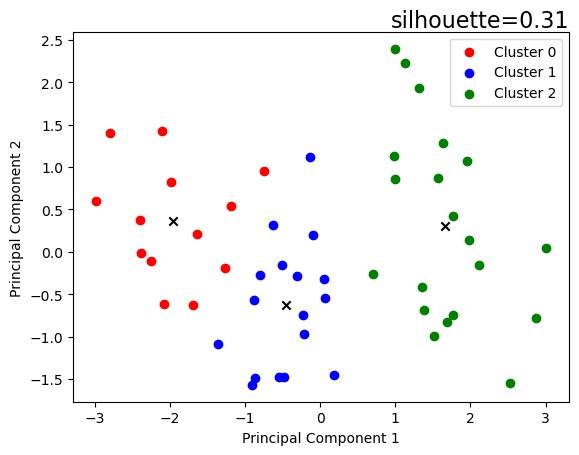

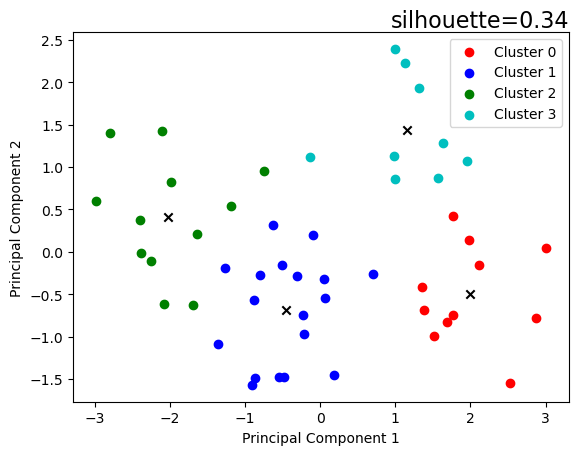

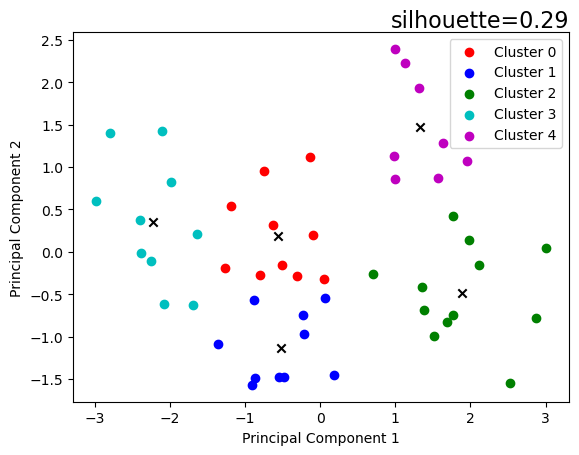

In [44]:
def scatter_Kmeans(x, k, r=123):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=r)
    y_pred = kmeans.fit_predict(x)
    colours = 'rbgcmy'
    for c in range(k):
      plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
      plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')
    
    score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'),2)
    plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

for k in range(2,6):
  scatter_Kmeans(X_clustering, k, r=0)

The analysis indicates that 2 clusters are the most optimal, hard, polythetic clusters. This is because the silhouette score, which measures intracluster distance mean and nearest cluster distance mean and assigns a score. Although 0.41 is quite a low score so even our best k cluster setting does not allow us to have hard, well defined clusters using k means clustering. Let us try hierarchical clustering and see which method can give us a better option.

#### Aglomerative Clustering

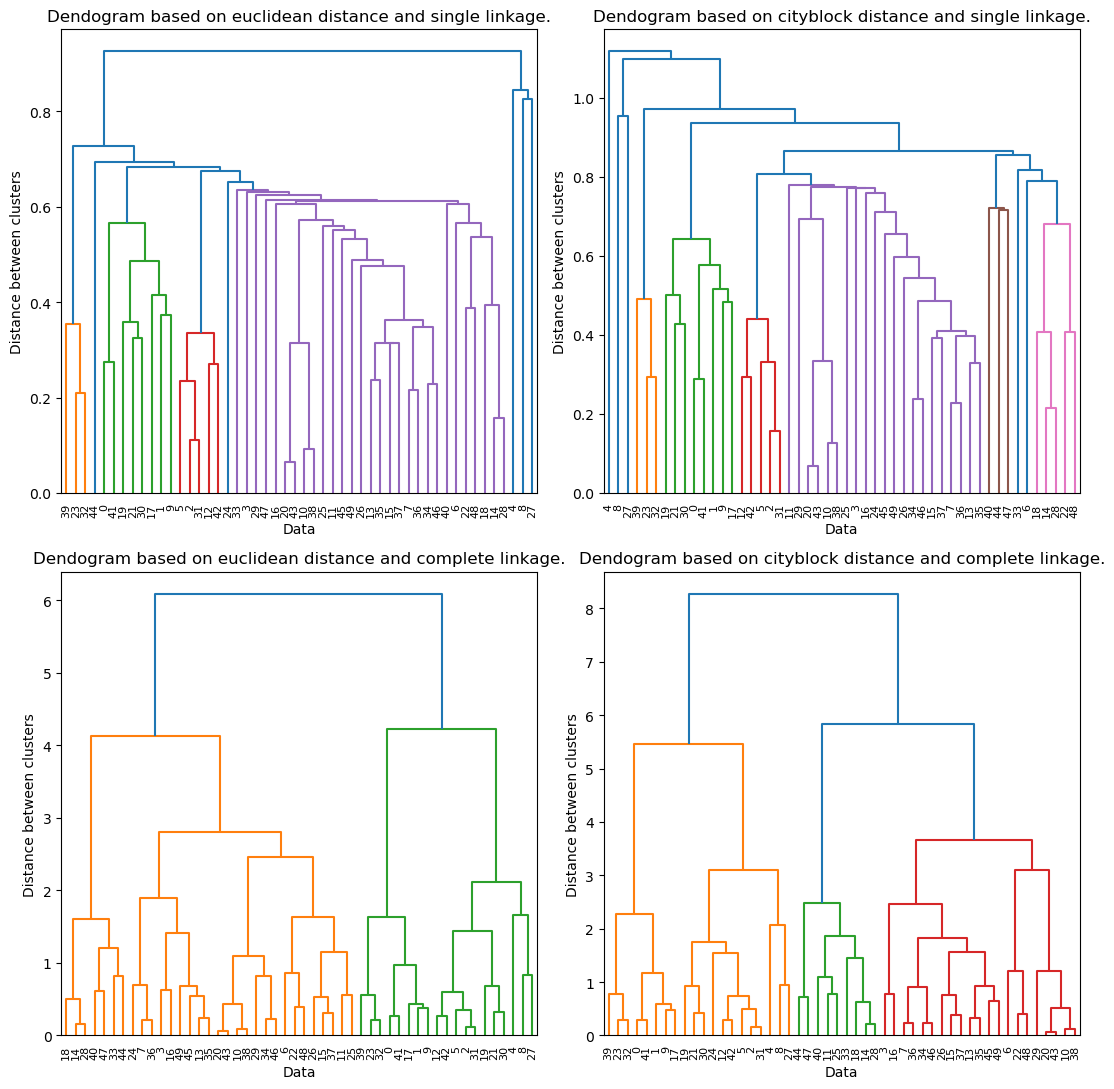

In [45]:
# generate 4 dendograms that use single and complete linkages, and Euclidean and Cityblock distance
linkages = ['single','complete']
distance = ['euclidean','cityblock']
fig,axes = plt.subplots(2,2,figsize=(11, 11))

for link_index,link_value in enumerate(linkages):
    for dist_index,dist_value in enumerate(distance):
        # run the unsupervised 
        link = linkage(y = X_clustering, method=link_value, metric = dist_value)
        dend = dendrogram(link, ax = axes[link_index,dist_index]) 
        # formatting
        axes[link_index,dist_index].set_title(f'Dendogram based on {dist_value} distance and {link_value} linkage.')
        axes[link_index,dist_index].set_xlabel('Data')
        axes[link_index,dist_index].set_ylabel('Distance between clusters')
        plt.tight_layout()
    

We can see from the range of graphs above that single linkage dendograms do not provide a clear view on the best number of clusters. Instead we see from euclidean and cityblock complete linkages that the best number of clusters/ those with the longest vertical distances between clusters is 2.

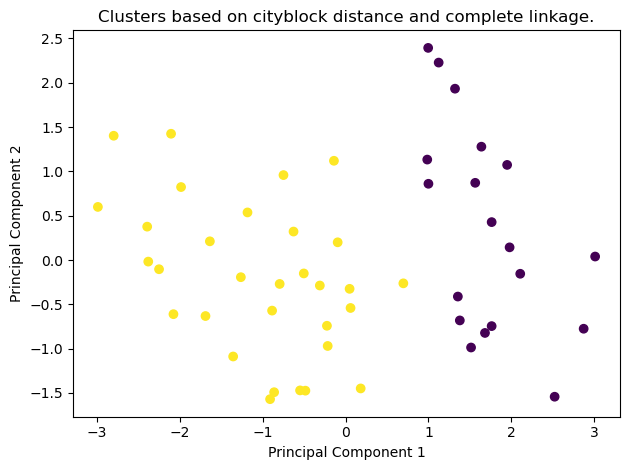

In [46]:
# Using k = 2 clusters we can see the visualise the clusters as follows
cluster = AgglomerativeClustering(n_clusters=2, affinity= 'Euclidean', linkage='complete')
pred = cluster.fit_predict(X_clustering)
plt.scatter(X_clustering[:,0], X_clustering[:,1], c=cluster.labels_)
plt.title(f'Clusters based on {dist_value} distance and {link_value} linkage.')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

In [47]:
print(f"""The Silouette score for euclidean, complete agglomerative clustering is with 2 clusters is {silhouette_score(X, labels = pred,metric = 'euclidean')}.
This is close to 1 which indicates that the clusters are well defined with lower levels of overlapping.""")

The Silouette score for euclidean, complete agglomerative clustering is with 2 clusters is 0.4047944502519567.
This is close to 1 which indicates that the clusters are well defined with lower levels of overlapping.
